
<h1>NLP Assignment_03</h1>

                                                                                                                              >Basha   2211ai03
                                                                                                                              >Ashok   2211ai22
                                                                                                                              >Sanatan 2211ai24



  > Importing Libraries

In [1]:
import spacy
import re
import sys
import os
import pandas as pd
import pandas as pd
import numpy as np
import nltk
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import LSTM,Dense,Flatten
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from progressbar import progressbar
from nltk.corpus import stopwords
pb = progressbar(2)

> Extracting Zip files to Locations

    > postive data to POS/pos Folder
    
    > Negetive Data to NEG/neg Folder

In [2]:
import zipfile

pos_zip="/content/pos.zip"

neg_zip="/content/neg.zip"

with zipfile.ZipFile(pos_zip, 'r') as zip_ref:
    
    zip_ref.extractall("/content/POS")
  
with zipfile.ZipFile(neg_zip, 'r') as zip_ref:
    
    zip_ref.extractall("/content/NEG")


# read_text function takes input folder locations of data


```
def read_text(folder_locations,max_files_toread): 
  returns list[list[str],list[int]
```



In [3]:

def read_text(folder_locations,max_files_toread):
    text_data=[]

    if type(folder_locations)!=str:

        text_file_Locations=[]

        for index,location in enumerate(folder_locations):

            text_file_Locations.append( [ os.path.join(location,file_name) for file_name in os.listdir(location)][:max_files_toread]  ) 

    else:

        print(" Folder locations in list or tuple format  \n\t ex:[Folder loc1,Folder loc2,Folder loc3]")

        return

    class_names = [0 for _ in folder_locations]

    present_length = 0

    for location_ind,text_file_Location in enumerate(text_file_Locations):

        for index,text_file in enumerate(text_file_Location):

            pb.print(index,len(text_file_Location))

            with open(text_file,'r',encoding='utf-8') as f:

                try:

                    text_data.append(f.readlines())

                except Exception as e:

                    print(e,text_file)

        class_names[location_ind]=len(text_data)-present_length

        present_length = len(text_data)

    class_labels=[]

    for index,no_of_files_inclass in enumerate(class_names):

        class_labels+=[index for number in range(no_of_files_inclass)]

    return text_data,class_labels

text_data,class_labels = read_text(["/content/NEG/neg","/content/POS/pos"],2000)

[>....................................................................................................] 
 


In [4]:
len(class_labels)

4000

In [5]:
text_data[1],class_labels[1]

(['OK, here it is: "Nazi mountaineer befriends the Dalai Lama." What we do is, first we get a major star with no idea whatsoever how to do a Germanic accent, and we let him flounder around between French, German, American, and British for over 2 hours. Then we concoct a series of wildly improbable events and space them apart very widely, so that the plot inches along almost imperceptibly. But just to make sure the viewer doesn´t fall asleep, we throw in details which are shockingly absurd, such as our hero smoking a cigarette at an altitude of 22,000 feet. Naturally, we must also remember that our target audience does not want to read too many subtitles, so we have every character, even the lowliest peasant in the forbidden closed-off city of Lhasa in 1943, speak perfect English, also with dubious accents. Of course, the trickiest part is how to handle the spiritual and political aspects of the story, so what we do is this: we have the Dalai Lama befriend the now-reformed Nazi because 

>Removing HTML tags from text data

In [6]:
regex = re.compile(r'<[^>]+>')

def remove_html(string):

    return regex.sub(' ', string)
    
text_data=[remove_html(text[0]) for text in text_data]

In [7]:
text_data[0]

"The direction struck me as poor man's Ingemar Bergman. The inaudible dialogue was annoying. The somber stoicism that all characters except Banderas' showed made me think they were drugged. I think the director ruined it for me."

# Data tokenizer

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def tokenize(texts):
    tokenized_texts=[]
    for text in texts:
      tokens = nltk.word_tokenize(text)
      filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
      tokenized_texts.append(filtered_tokens)
    return tokenized_texts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
tokenized_texts = tokenize( text_data)

# Downloading GLOVE existing database

In [11]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [12]:
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2023-04-12 16:31:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-12 16:31:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-12 16:31:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [13]:
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [14]:
import numpy as np
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [15]:
def freqent_tokens( text_data, frequency=5 ):

    counter={}

    for text in text_data:

        for token in text:

            if token in counter:

                counter[token]+=1

            else:

                counter[token]=1

    freq_tokens=[]

    for i in counter.items():
      
      if i[1]>frequency:

        freq_tokens.append(i[0])


    return freq_tokens

# freq_tokens = freqent_tokens(tokenized_texts,frequency=300)

# f" Most frequent Tokens length  {len(freq_tokens)}"

In [16]:
tokenized_texts[1][:10]

['OK',
 ',',
 ':',
 '``',
 'Nazi',
 'mountaineer',
 'befriends',
 'Dalai',
 'Lama',
 '.']

# Padding sequences

In [17]:
def Pad_sequences(sequences):
    avg_len=0

    for text in sequences:

        avg_len+=len(text)

    avg_len=int((avg_len)/len(tokenized_texts))*2

    for text_ind,text in enumerate(sequences):

        if len(text)>=avg_len:

            sequences[text_ind]=text[:avg_len]

        else:

            for i in range(avg_len-len(text)):
              
              sequences[text_ind].append('PAD')
              
Pad_sequences(tokenized_texts)

In [18]:
embeddings_index['unk']

array([ 0.027166 , -0.1762   , -0.19623  ,  0.33527  ,  0.062392 ,
       -0.29748  ,  0.46416  , -0.13271  ,  0.38312  , -0.37872  ,
        0.53709  , -0.071442 , -0.15837  ,  0.049163 , -0.2225   ,
        0.33305  ,  0.11272  , -0.10672  ,  0.48584  , -0.19743  ,
       -0.8179   , -0.43915  , -0.68904  , -0.23316  ,  0.082357 ,
        0.49117  , -0.08154  ,  0.10273  ,  0.39784  ,  0.68379  ,
       -0.072532 , -0.26836  ,  0.52545  , -0.14456  , -0.3563   ,
       -0.19699  ,  0.28968  , -0.71389  ,  0.10056  ,  0.41272  ,
        0.52239  , -0.26027  ,  0.016722 ,  0.54869  ,  0.076753 ,
        0.010193 , -0.11065  ,  0.47543  , -0.20591  ,  0.11673  ,
       -0.096665 ,  0.13824  , -0.16024  , -0.43239  ,  0.23957  ,
        0.21804  ,  0.48378  ,  0.27944  , -0.74636  , -0.60598  ,
       -0.37709  ,  0.28384  , -0.1613   , -0.0017167,  0.35972  ,
        0.091564 , -0.070139 , -0.9614   , -0.25841  ,  0.33928  ,
        0.44946  , -0.1805   ,  0.051543 ,  0.26107  ,  0.1668

# converting words to one hot coding vectors

In [19]:
def one_hot_coding(tokenized_texts):
    
    # token_to_number={x:to_categorical(ind,num_classes=len(freq_tokens)+1,dtype='uint8') for ind,x in enumerate(freq_tokens)}

    # token_to_number['unk']=np.array([0 for x in range(len(freq_tokens))]+[1])

    for text in tokenized_texts:

      for token_ind,token in enumerate(text):

        if token in embeddings_index:

          text[token_ind]=embeddings_index[token]

        else:

          text[token_ind]=embeddings_index['unk']
      
one_hot_coding(tokenized_texts)

In [20]:
X = np.array(tokenized_texts)

In [21]:
Data_set_1=X

# Reading tweets Dataset

In [22]:
X.shape

(4000, 306, 100)

In [23]:
data2=pd.read_csv("/content/2013semeval_train.csv")

In [24]:
data2.tweet

0       Gas by my house hit $3.39!!!! I\u2019m going t...
1       Theo Walcott is still shit\u002c watch Rafa an...
2       its not that I\u2019m a GSP fan\u002c i just h...
3       Iranian general says Israel\u2019s Iron Dome c...
4       Tehran\u002c Mon Amour: Obama Tried to Establi...
                              ...                        
9679    RT @MNFootNg It's monday and Monday Night Foot...
9680    All I know is the road for that Lomardi start ...
9681    "All Blue and White fam, we r meeting at Golde...
9682    @DariusButler28   Have a great game agaist Tam...
9683    "I'm pisseeedddd that I missed Kid Cudi's show...
Name: tweet, Length: 9684, dtype: object

#Cleaning unicodes out of text

In [25]:
unicode_escape_regex = re.compile(r'\\u([0-9a-fA-F]{4})')

def convert_escape_sequence(match):
    return chr(int(match.group(1), 16))

result = unicode_escape_regex.sub(convert_escape_sequence, data2.tweet[1])
def change_string(string):
    return unicode_escape_regex.sub(convert_escape_sequence,string)
print(result)

Theo Walcott is still shit, watch Rafa and Johnny deal with him on Saturday.


In [26]:
data2.tweet=data2.tweet.apply(change_string)

#Tokenizing

In [27]:
tokenized_texts = tokenize( data2.tweet )

#Calculating freq tokens

In [28]:
freq_tokens = freqent_tokens(tokenized_texts,frequency=200)

f" Most frequent Tokens length  {len(freq_tokens)}"

' Most frequent Tokens length  60'

#Padding and converting to one_hot_coding

In [29]:
Pad_sequences(tokenized_texts)      
one_hot_coding(tokenized_texts)

In [30]:
X = np.array(tokenized_texts,dtype='uint8')

In [31]:
Data_set_2=X

In [32]:
Data_set_1.shape,Data_set_2.shape

((4000, 306, 100), (9684, 34, 100))

# Convertin dataset_1 labels to numpy array

In [33]:
Data_set_1_labels=np.array(class_labels)

#Converting dataset_2 labels to numpy array

In [34]:
unique_labels={x:ind for ind,x in enumerate(data2.label.unique())}

In [35]:
data2.label = data2.label.apply(lambda x:unique_labels[x])

In [36]:
Data_set_2_labels = data2.label.values

#Final Data 

In [37]:
Data_set_1.shape,Data_set_1_labels.shape,Data_set_2.shape,Data_set_2_labels.shape

((4000, 306, 100), (4000,), (9684, 34, 100), (9684,))

# Recurrent Neural Network Models

In [47]:
model_1_RNN=keras.Sequential([
    LSTM(500,input_shape=Data_set_1.shape[1:]),
    Dense(2,activation='sigmoid')
])
model_1_RNN.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model_2_RNN=keras.Sequential([
    LSTM(500,input_shape=Data_set_2.shape[1:]),
    Dense(3,activation='sigmoid')
])
model_2_RNN.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [39]:
model_1_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 500)               1202000   
                                                                 
 dense (Dense)               (None, 2)                 1002      
                                                                 
Total params: 1,203,002
Trainable params: 1,203,002
Non-trainable params: 0
_________________________________________________________________


In [40]:
from sklearn.model_selection import train_test_split

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(Data_set_1, Data_set_1_labels, test_size=0.25, random_state=42)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(Data_set_2, Data_set_2_labels, test_size=0.25, random_state=42)

In [49]:
history_1 = model_1_RNN.fit(x_train_1,y_train_1,epochs=30)

Epoch 1/30
94/94 [==============================] - 5s 51ms/step - loss: 0.6262 - accuracy: 0.5530
Epoch 2/30
94/94 [==============================] - 4s 42ms/step - loss: 0.6260 - accuracy: 0.5490
Epoch 3/30
94/94 [==============================] - 4s 43ms/step - loss: 0.6244 - accuracy: 0.5480
Epoch 4/30
94/94 [==============================] - 4s 44ms/step - loss: 0.6250 - accuracy: 0.5447
Epoch 5/30
94/94 [==============================] - 4s 44ms/step - loss: 0.6216 - accuracy: 0.5667
Epoch 6/30
94/94 [==============================] - 4s 44ms/step - loss: 0.6192 - accuracy: 0.5583
Epoch 7/30
94/94 [==============================] - 4s 45ms/step - loss: 0.6172 - accuracy: 0.5780
Epoch 8/30
94/94 [==============================] - 4s 45ms/step - loss: 0.6047 - accuracy: 0.6317
Epoch 9/30
94/94 [==============================] - 4s 44ms/step - loss: 0.6200 - accuracy: 0.5873
Epoch 10/30
94/94 [==============================] - 4s 44ms/step - loss: 0.5662 - accuracy: 0.6930
Epoch 11/

In [42]:
history_2 = model_2_RNN.fit(x_train_2,y_train_2,epochs=20)

Epoch 1/20
227/227 [==============================] - 4s 7ms/step - loss: 0.9631 - accuracy: 0.5294
Epoch 2/20
227/227 [==============================] - 2s 8ms/step - loss: 0.8875 - accuracy: 0.5927
Epoch 3/20
227/227 [==============================] - 2s 8ms/step - loss: 0.8206 - accuracy: 0.6351
Epoch 4/20
227/227 [==============================] - 2s 8ms/step - loss: 0.7551 - accuracy: 0.6828
Epoch 5/20
227/227 [==============================] - 2s 7ms/step - loss: 0.6859 - accuracy: 0.7165
Epoch 6/20
227/227 [==============================] - 2s 7ms/step - loss: 0.6195 - accuracy: 0.7527
Epoch 7/20
227/227 [==============================] - 2s 7ms/step - loss: 0.5541 - accuracy: 0.7818
Epoch 8/20
227/227 [==============================] - 2s 7ms/step - loss: 0.4931 - accuracy: 0.8083
Epoch 9/20
227/227 [==============================] - 2s 7ms/step - loss: 0.4416 - accuracy: 0.8317
Epoch 10/20
227/227 [==============================] - 2s 7ms/step - loss: 0.3827 - accuracy: 0.8564

In [50]:
from sklearn.metrics import precision_recall_fscore_support
y_pred_1=model_1_RNN.predict(x_test_1)
scores=precision_recall_fscore_support(np.argmax(y_pred_1,axis=1),y_test_1,average='macro')
print(f"""\n\nRNN Model_1 For DataSet1
    Precision = {scores[0]}
    Recall    = {scores[1]}
    f1_score  = {scores[2]}
""")

32/32 [==============================] - 1s 21ms/step


RNN Model_1 For DataSet1
    Precision = 0.7792113028417473
    Recall    = 0.7786582852844322
    f1_score  = 0.7787590686257335



In [51]:
from sklearn.metrics import precision_recall_fscore_support
y_pred_2=model_2_RNN.predict(x_test_2)
scores=precision_recall_fscore_support(np.argmax(y_pred_2,axis=1),y_test_2,average='macro')
print(f"""\n\nRNN Model_2 For DataSet_2
    Precision = {scores[0]}
    Recall    = {scores[1]}
    f1_score  = {scores[2]}
""")

76/76 [==============================] - 1s 3ms/step


RNN Model_2 For DataSet_2
    Precision = 0.3348488756404327
    Recall    = 0.3076271734206232
    f1_score  = 0.2297515481098211



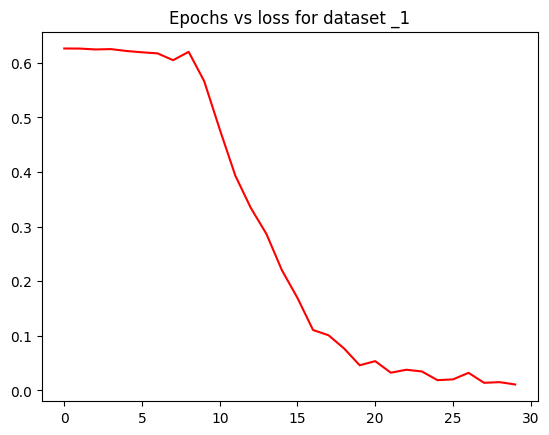

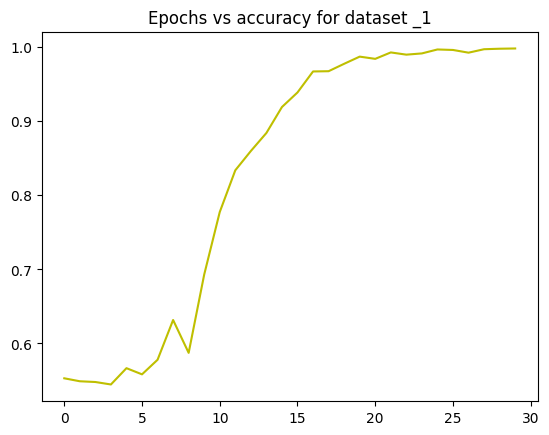

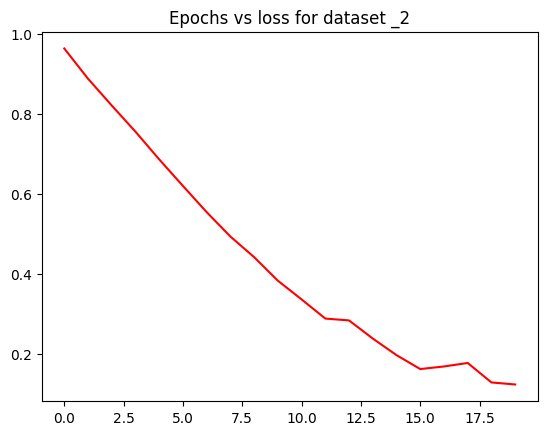

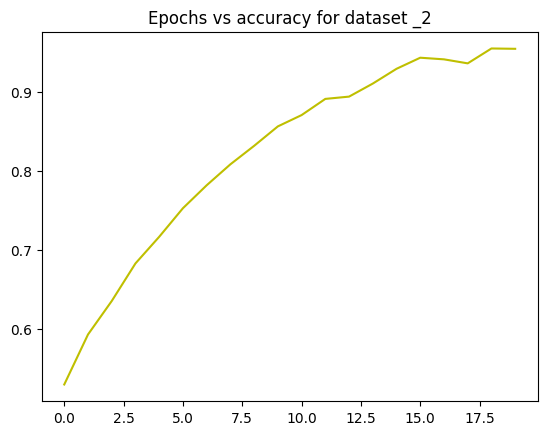

In [52]:
plt.plot([x for x in range(len(history_1.history['loss']))],history_1.history['loss'],c='r')
plt.title("Epochs vs loss for dataset _1")
plt.x_label="Epochs"
plt.y_label="Loss"
plt.show()
plt.plot([x for x in range(len(history_1.history['accuracy']))],history_1.history['accuracy'],c='y')
plt.title("Epochs vs accuracy for dataset _1")
plt.x_label="Epochs"
plt.y_label="Loss"
plt.show()
plt.plot([x for x in range(len(history_2.history['loss']))],history_2.history['loss'],c='r')
plt.title("Epochs vs loss for dataset _2")
plt.x_label="Epochs"
plt.y_label="Loss"
plt.show()
plt.plot([x for x in range(len(history_2.history['accuracy']))],history_2.history['accuracy'],c='y')
plt.title("Epochs vs accuracy for dataset _2")
plt.x_label="Epochs"
plt.y_label="Loss"
plt.show()

# Feed forward Neural Networks 

The feed-forward neural network (FFNN) architecture I am proposing has two hidden layers with non-linear activation functions between them. The input layer is connected to the first hidden layer, which has 256 neurons. The first hidden layer is connected to the second hidden layer, which has 128 neurons. Finally, the second hidden layer is connected to the output layer, whose size depends on the number of classes in the problem.

Here is a visual representation of the architecture:



```
Input Layer (Size depends on input data)
            |
            v
Hidden Layer 1 (Size: 256) with Non-linearity
            |
            v
Hidden Layer 2 (Size: 128) with Non-linearity
            |
            v
Output Layer (Size depends on the number of classes)
```



The choice of non-linearity for this architecture is left open, with some popular choices being the Rectified Linear Unit (ReLU), hyperbolic tangent (tanh), or Gaussian Error Linear Unit (GELU).

For binary classification problems, the binary cross-entropy loss function is often used. For multi-class classification problems, the categorical cross-entropy loss function is commonly used.

Feed-Forward Neural Networks are useful for several reasons:

    They are capable of modeling complex non-linear relationships between inputs and outputs.
    They are relatively simple to understand and implement.
    They can be trained efficiently on large datasets using techniques like stochastic gradient descent and backpropagation.
    They can be applied to a wide range of problems, including classification, regression, and prediction.

However, FFNNs are limited in their ability to handle sequential or time-series data, as they do not take into account the temporal relationships between inputs. They are also prone to overfitting if the model is too complex or if the dataset is too small.

In [46]:
with open("logs for GLOVE model.txt" , 'w') as f:
  for ind,history in enumerate([history_1,history_2]):
    for data in ['loss','accuracy']:
      for epoch,value in enumerate(history.history[data]):
        f.writelines(f"""For dataset_{ind+1} 
                        \t\t\t For epoch_{epoch} \t{data}= {round(value,2)}\n""")
